<a href="https://colab.research.google.com/github/Peter-obi/JAX/blob/main/Working_with_arrays_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import jax.numpy as np
from jax.scipy.signal import convolve2d
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.util import (img_as_float32, img_as_ubyte, random_noise)

In [26]:
img = imread('The_Cat.jpg')

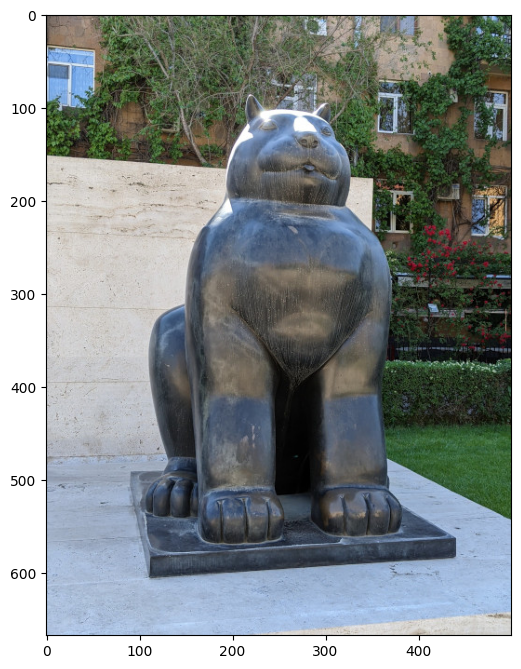

In [27]:
plt.figure(figsize= (6,10))
plt.imshow(img)

In [28]:
type(img)

numpy.ndarray

In [29]:
img.ndim

3

In [30]:
img.shape

(667, 500, 3)

In [31]:
img.size

1000500

In [32]:
img.nbytes

1000500

In [33]:
cat_face = img[80:220, 190:330, 1] #1 is the green channel
cat_face.shape

(140, 140)

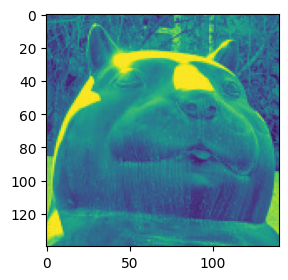

In [34]:
plt.figure(figsize= (3,4))
plt.imshow(cat_face)

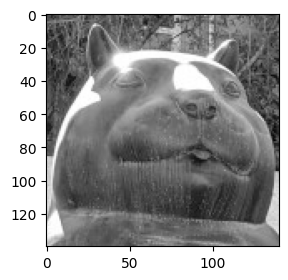

In [35]:
plt.figure(figsize= (3,4))
plt.imshow(cat_face, cmap = 'gray')

In [36]:
img_flip = img[:,::-1, :]

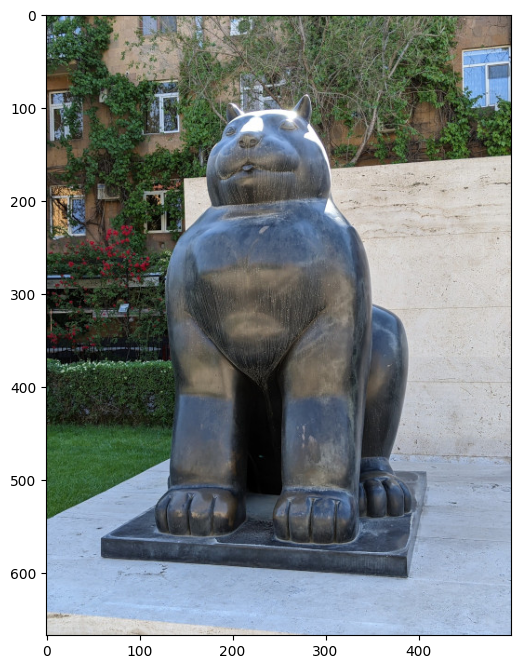

In [37]:
plt.figure(figsize= (6,10))
plt.imshow(img_flip)

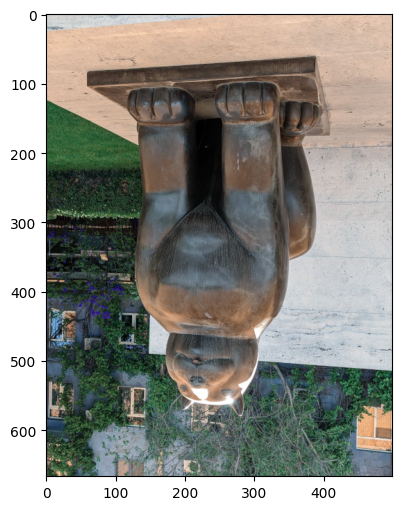

In [38]:
img_flip = np.flip(img)
plt.figure(figsize=(10, 6))
plt.imshow(img_flip)

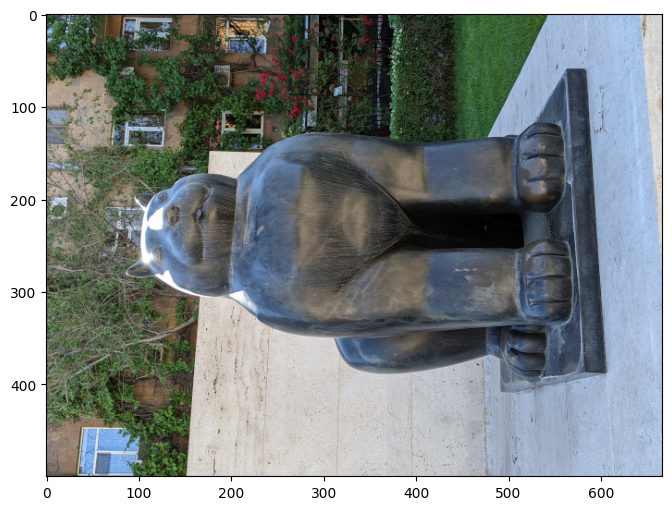

In [39]:
img_rot = np.rot90(img, k = 1, axes = (0,1))
plt.figure(figsize=(10, 6))
plt.imshow(img_rot)

In [40]:
img = img_as_float32(img)
img.dtype

dtype('float32')

##Create noised image

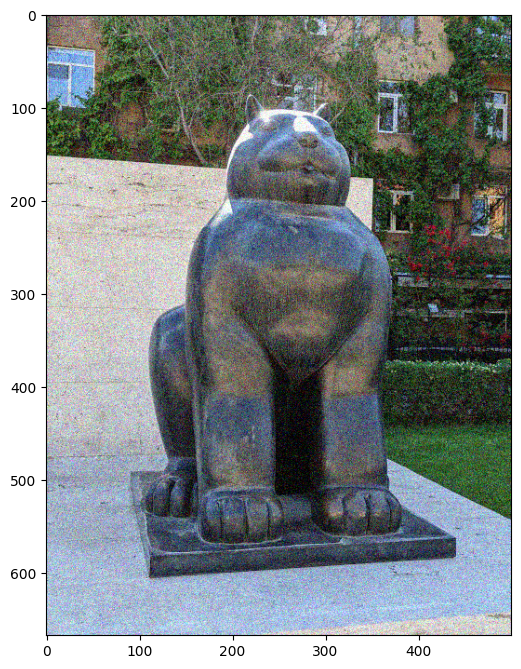

In [41]:
img_noised = random_noise(img, mode = 'gaussian')
plt.figure(figsize=(6, 10))
plt.imshow(img_noised)

##Simple blur filter

In [42]:
kernel_blur = np.ones((5, 5))
kernel_blur /= np.sum(kernel_blur)
kernel_blur

Array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]], dtype=float32)

In [43]:
type(kernel_blur)

jaxlib._jax.ArrayImpl

##Gaussian blur kernel

In [44]:
def gaussian_blur(kernel_size, sigma = 1.0, mu = 0.0):
  """A function to generate Gaussian 2D kernel"""
  center = kernel_size // 2
  x, y = np.mgrid[
      -center : kernel_size - center,
      -center : kernel_size - center] #create a 5x5 array going from -2 to 5 - 2 = 3 ie -2:3
  d = np.sqrt(np.square(x) + np.square(y)) #calculate the euclidean distance
  koeff = 1 /(2 * np.pi * np.square(sigma))
  kernel = koeff * np.exp(-np.square(d - mu) / (2 * np.square(sigma))) #make the values are center bigger
  return kernel

kernel_gauss = gaussian_blur(5)
kernel_gauss

Array([[0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.02153928, 0.09653235, 0.15915494, 0.09653235, 0.02153928],
       [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
       [0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502]],      dtype=float32)

In [45]:
def color_convolution(image, kernel):
  """A function to apply a filter to an image"""
  channels = []
  for i in range(3):
    color_channel = image[:, :, i] # extract channel by slicing, assumes channel is in the last dimension
    filtered_channel = convolve2d(color_channel, kernel, mode = 'same') # applies filter to the channel
    filtered_channel = np.clip(filtered_channel, 0.0, 1.0) #clip values
    channels.append(filtered_channel)
  final_image = np.stack(channels, axis = 2) #concatenate filtered channels
  return final_image

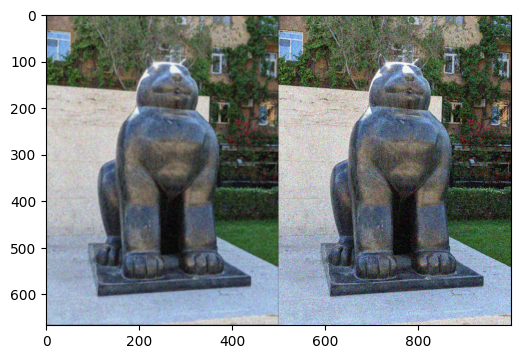

In [46]:
img_blur = color_convolution(img_noised, kernel_gauss) #apply filter to noised image
plt.figure(figsize = (6,10))
plt.imshow(np.hstack((img_blur, img_noised)))

In [47]:
kernel_sharpen = np.array(
[[-1, -1, -1, -1, -1],
[-1, -1, -1, -1, -1],
[-1, -1, 50, -1, -1],
[-1, -1, -1, -1, -1],
[-1, -1, -1, -1, -1]], dtype=np.float32
) #create a kernel with a large +ve value in the middle and small -ve values everywhere else since conolution is a weighted sum of neghbors so we amplify center
kernel_sharpen /= np.sum(kernel_sharpen) #normalize to sum to 1 so image doesn't get brighter overall
kernel_sharpen

Array([[-0.03846154, -0.03846154, -0.03846154, -0.03846154, -0.03846154],
       [-0.03846154, -0.03846154, -0.03846154, -0.03846154, -0.03846154],
       [-0.03846154, -0.03846154,  1.9230769 , -0.03846154, -0.03846154],
       [-0.03846154, -0.03846154, -0.03846154, -0.03846154, -0.03846154],
       [-0.03846154, -0.03846154, -0.03846154, -0.03846154, -0.03846154]],      dtype=float32)

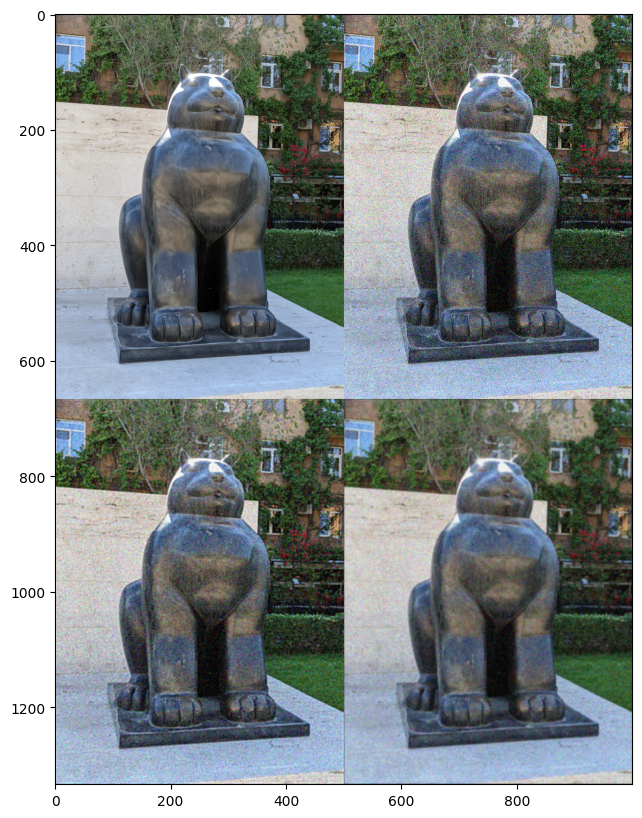

In [48]:
img_restored = color_convolution(img_blur, kernel_sharpen)
plt.figure(figsize = (12, 10))
plt.imshow(np.vstack((np.hstack((img, img_noised)), np.hstack((img_restored, img_blur)))))

In [49]:
img_modified = img_as_ubyte(img_restored)
imsave('The_Cat_modified.jpg', arr = img_modified)